In [3]:
from datasets import load_dataset 

dataset = load_dataset("ybelkada/football-dataset", split="train")

Generating train split:   0%|          | 0/6 [00:00<?, ? examples/s]

In [4]:
dataset[0]["text"]

"Benzema after Real Mardid's win against PSG"

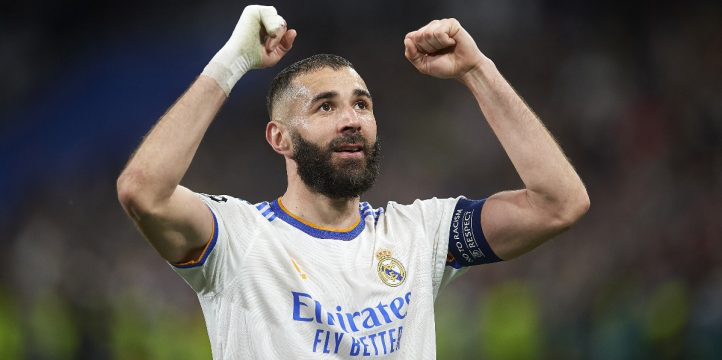

In [5]:
dataset[0]["image"]

In [6]:
from torch.utils.data import Dataset, DataLoader

MAX_PATCHES = 1024

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], return_tensors="pt", add_special_tokens=True, max_patches=MAX_PATCHES)
        
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

In [9]:
from transformers import AutoProcessor, Pix2StructForConditionalGeneration

processor = AutoProcessor.from_pretrained("ybelkada/pix2struct-base")
model = Pix2StructForConditionalGeneration.from_pretrained("ybelkada/pix2struct-base")

model.safetensors:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

ChunkedEncodingError: ('Connection broken: IncompleteRead(9115059 bytes read, 1120062917 more expected)', IncompleteRead(9115059 bytes read, 1120062917 more expected))

In [ ]:
import torch
def collator(batch):
  new_batch = {"flattened_patches":[], "attention_mask":[]}
  texts = [item["text"] for item in batch]
  
  text_inputs = processor(text=texts, padding="max_length", return_tensors="pt", add_special_tokens=True, max_length=20)
  
  new_batch["labels"] = text_inputs.input_ids
  
  for item in batch:
    new_batch["flattened_patches"].append(item["flattened_patches"])
    new_batch["attention_mask"].append(item["attention_mask"])
  
  new_batch["flattened_patches"] = torch.stack(new_batch["flattened_patches"])
  new_batch["attention_mask"] = torch.stack(new_batch["attention_mask"])

  return new_batch

In [ ]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2, collate_fn=collator)

In [ ]:
EPOCHS = 5000

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(EPOCHS):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    labels = batch.pop("labels").to(device)
    flattened_patches = batch.pop("flattened_patches").to(device)
    attention_mask = batch.pop("attention_mask").to(device)

    outputs = model(flattened_patches=flattened_patches,
                    attention_mask=attention_mask,
                    labels=labels)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    if (epoch + 1) % 20 == 0:
        model.eval()

        predictions = model.generate(flattened_patches=flattened_patches, attention_mask=attention_mask)        
        print("Predictions:", processor.batch_decode(predictions, skip_special_tokens=True))

        model.train()

In [21]:
from transformers import AutoModel,AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("F:/FigureQANet/transformers_bert/microsoft/codebert")
text_encoder = AutoModel.from_pretrained("F:/FigureQANet/transformers_bert/microsoft/codebert",output_hidden_states=True,output_attentions=True)
text_encoder.eval()

tokens = tokenizer("Hello World", return_tensors="pt")
tokens

{'input_ids': tensor([[    0, 31414,   623,     2]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [22]:
embeddings = text_encoder(**tokens)

In [24]:
embeddings.last_hidden_state.shape

torch.Size([1, 4, 768])

In [25]:
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self,in_feature,output_feature):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(in_feature,output_feature)
        
    def forward(self,x):
        return self.fc1(x)
    
    
MyModel = MyModel(768,512)

In [28]:
outputs = MyModel(embeddings.last_hidden_state)

In [29]:
outputs.shape

torch.Size([1, 4, 512])

In [7]:
from torchvision import models

model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
model.classifier[-1].in_features